In [68]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pylab as pl
import seaborn as sns
sns.set_style('whitegrid')

# UDPNY 2018 - _phase #3_
# _new edition according to udp methodology and revision - September '18_

This code defines the _**8 displacement typologies**_ and assignes each tract to a typology. 

- [UDP's methodology / displacement typollogies](https://drive.google.com/file/d/1nwOoVItI5RLLILrFpbTRoXbrjIohnSPY/view)

----
# UDP Gentrification and Displacement Typologies
The typologies (**Updated to October 2018**) can be found in the udp website under _[Gentrification and Displacement Census Tract Typologies](https://drive.google.com/file/d/1nwOoVItI5RLLILrFpbTRoXbrjIohnSPY/view])_
### _8 Typologies_ to be generated to the displacement map:

### Low Income:
1. LI - Not Losing Low-Income Households
2. LI - At Risk of Gentrification
3. LI - Ongoing Displacement of Low-Income Households
4. LI - Ongoing Gentrification 

### Moderate to High Income:
5. MHI - Advanced Gentrification
6. MHI - Not Losing Low-Income Households
7. MHI - At Risk of Exclusion
8. MHI - Displacement of Low-Income Households - Ongoing Exclusion 

---
# 1. Data 
- This notebook uses the data was given by the Berkeley UDP team for the New-York region;
- For the data aquisition process, including logistic regressions for the variables please refer to https://github.com/geeroovaa/udp

In [69]:
# unhash the following line if reading .dta file:
# data = pd.read_stata("data/UDP_NYC_Variables.dta")

# reading .csv file:
data = pd.read_csv("https://raw.githubusercontent.com/geeroovaa/udp/master/UDPNY_gerardo_11_07_18.csv")

print(data.shape)
data.iloc[:3,-5:]

(5956, 146)


,empd02,TOD,TOD_pre_00,TOD_00_10,TOD_10
0,398,False,False,False,False
1,222,False,False,False,False
2,364,False,False,False,False


In [70]:
list(data.columns)

['Unnamed: 0',
 'NAME',
 'county',
 'hh_00',
 'hh_16',
 'hh_16_moe',
 'hh_90',
 'hi_00',
 'hi_16',
 'hi_16_moe',
 'hi_90',
 'hi_mig_10',
 'hi_mig_10_moe',
 'hi_mig_16',
 'hi_mig_16_moe',
 'hinc_00',
 'hinc_16',
 'hinc_16_moe',
 'hinc_90',
 'hu_00',
 'hu_16',
 'hu_16_moe',
 'hu_90',
 'li_00',
 'li_16',
 'li_16_moe',
 'li_90',
 'li_mig_10',
 'li_mig_10_moe',
 'li_mig_16',
 'li_mig_16_moe',
 'mhi_00',
 'mhi_16',
 'mhi_16_moe',
 'mhi_90',
 'mhi_mig_10',
 'mhi_mig_10_moe',
 'mhi_mig_16',
 'mhi_mig_16_moe',
 'mhval_00',
 'mhval_16',
 'mhval_16_moe',
 'mhval_90',
 'mi_00',
 'mi_16',
 'mi_16_moe',
 'mi_90',
 'mi_mig_10',
 'mi_mig_10_moe',
 'mi_mig_16',
 'mi_mig_16_moe',
 'mrent_00',
 'mrent_16',
 'mrent_16_moe',
 'mrent_90',
 'per_all_li_mig_10',
 'per_all_li_mig_16',
 'per_asian_00',
 'per_asian_16',
 'per_asian_16_moe',
 'per_asian_90',
 'per_black_00',
 'per_black_16',
 'per_black_16_moe',
 'per_black_90',
 'per_built_00_16',
 'per_built_80_90',
 'per_built_90_00',
 'per_burden_00',
 'per_b

## 1.1 Data cleaning and munging
- Dropping tracts with _**population less than 500**_ (2016)
- Dropping tracts with _**more than 5 'Null' columns**_
- calculating coefficient of variation according to MOE (drop **_> 30% of variation_**)
- reading in tracts' shapefile in order to claculate _**pop densities**_

In [71]:
print("# of tracts in data before cleaning: ", data.shape[0])

# Dropping tracts with population less than 500 (2016)
data = data[data['pop_16'] > 500]
# Dropping tracts with more than 5 'Null' columns
data = data[data.isnull().sum(axis=1) <= 5]

print("# of tracts in data after cleaning: ", data.shape[0])

# of tracts in data before cleaning:  5956
# of tracts in data after cleaning:  5944


In [72]:
data.tail(1)

,Unnamed: 0,NAME,county,hh_00,hh_16,hh_16_moe,hh_90,hi_00,hi_16,hi_16_moe,...,vli_mig_10_moe,vli_mig_16,vli_mig_16_moe,downtown,empd15,empd02,TOD,TOD_pre_00,TOD_00_10,TOD_10
5955,9015830100,"Census Tract 8301, Windham County, Connecticut",15,1574.0,1659.0,105.0,1428.0,0.162402,0.149289,0.059018,...,0.174726,0.457672,0.134416,False,526,367,False,False,False,False


### Coefficient of variation of MOE
## _Tracts with a coefficient of variation > 30% on several key 2016 variables are flagged and determined unreliable:_
- Population -- V
- Housing units -- V
- Median rent -- V
- Median home value -- V
- Median income  -- **_no MOE in the data_**
- College count
- Renter count -- V

In [66]:
# Population
data = data[(data.pop_16_moe / 1.645 ) / data.pop_16 <= 0.3]
# Housing Units
data = data[(data.hu_16_moe / 1.645 ) / data.hu_16 <= 0.3]
# Bachelors count
data = data[(data.per_col_16_moe / 1.645 ) / data.per_col_16 <= 0.3]

# Renter counts, Median rent, Median home value
# dividing data to ct with majority of renters vs homeowners
datarent = data[data.per_rent_16 > 0.5]
dataowner = data[data.per_rent_16 <= 0.5]

# Renter count, ownership counts
# datarent = datarent[(datarent.moe_renter16 / 1.645)  / datarent.rhu16 <= 0.3]
# dataowner = dataowner[(dataowner.moe_owner16 / 1.645 ) / dataowner.ohu16 <= 0.3]

# Median rent, Median home value
datarent = datarent[(datarent.mrent_16_moe / 1.645)  / datarent.mrent_16 <= 0.3]
dataowner = dataowner[(dataowner.mhval_16_moe / 1.645 ) / dataowner.mhval_16 <= 0.3]

# concatenating two datasets back to 'data'
data = [dataowner, datarent]
data = pd.concat(data)
data.shape

(4271, 146)

In [67]:
(5944-data.shape[0]) / 5944

0.2814602960969044

### _4,271 CT were found valid for the analysis -- 28% were dropped._ 

### Census tracts shapefiles + calculating population densities

In [64]:
print(data.iloc[:5,:1])
data['Unnamed: 0'] = data['Unnamed: 0'].astype(str)
data['Unnamed: 0'] = data['Unnamed: 0'].apply(lambda x: '{0:0>11}'.format(x))
print(data.iloc[:,:1].dtypes)

    Unnamed: 0
0  34001000100
1  34001000200
2  34001000300
3  34001000400
4  34001000500
Unnamed: 0    object
dtype: object


In [65]:
print(len(data['Unnamed: 0'].unique()))
print(data['state'].unique())

5944
[34 36  9]


In [53]:
Alltracts = gpd.GeoDataFrame.from_file("data/MM_Tracts_CSA-NYMetro/MM_Tracts_CSA-NYMetro.shp")
Alltracts = Alltracts[Alltracts['CSA'] == '408'].reset_index()
Alltracts = Alltracts[['GEOID', 'ALAND_mi', 'geometry']]
Alltracts['GEOID'] = Alltracts['GEOID'].apply(lambda x: '{0:0>11}'.format(x))

print(Alltracts.shape)
print(Alltracts.dtypes)
Alltracts.head()

(5297, 3)
GEOID        object
ALAND_mi    float64
geometry     object
dtype: object


,GEOID,ALAND_mi,geometry
0,34003003200,0.47916,"POLYGON ((-74.000221 40.914034, -73.9994909999..."
1,34003003402,0.40644,"POLYGON ((-74.01045499999999 40.914168, -74.00..."
2,34003004002,0.42869,"POLYGON ((-74.03627399999999 40.879097, -74.03..."
3,34003015500,1.43050,"POLYGON ((-73.984858 40.87487, -73.98401799999..."
4,34003023401,0.16760,"POLYGON ((-74.06457 40.887063, -74.062236 40.8..."


In [54]:
print(len(Alltracts['GEOID'].unique()))
print(Alltracts['GEOID'].unique())

5297
['34003003200' '34003003402' '34003004002' ... '09009154900' '09009165801'
 '09001055100']


In [55]:
data_shp = Alltracts.merge(data, left_on='GEOID', right_on='Unnamed: 0').drop('Unnamed: 0', axis=1)\
                                                                              .set_index('GEOID')

# calculate pop density at 2016
data_shp['pop_density16'] = data_shp['pop_16'] / data_shp['ALAND_mi']

# replicating data_shp to data
data = data_shp.drop(['ALAND_mi'], axis=1)

print(type(data_shp))
print(type(data))
print(data.shape)
data.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
(4128, 147)


,geometry,NAME,county,hh_00,hh_16,hh_16_moe,hh_90,hi_00,hi_16,hi_16_moe,...,vli_mig_16,vli_mig_16_moe,downtown,empd15,empd02,TOD,TOD_pre_00,TOD_00_10,TOD_10,pop_density16
GEOID,,,,,,,,,,,,,,,,,,,,,
34003023401,"POLYGON ((-74.06457 40.887063, -74.062236 40.8...","Census Tract 234.01, Bergen County, New Jersey",3,1785.0,1714.0,105.0,1764.0,0.075360,0.085411,0.052440,...,0.497166,0.222092,False,461,478,False,False,False,False,23013.126492
34003030100,"POLYGON ((-74.08288399999999 40.879418, -74.08...","Census Tract 301, Bergen County, New Jersey",3,2053.0,1952.0,139.0,2018.0,0.070906,0.034361,0.029258,...,0.707010,0.310734,False,2316,2634,False,False,False,False,6412.055759
34003033300,"POLYGON ((-74.068018 40.889893, -74.0670339999...","Census Tract 333, Bergen County, New Jersey",3,1366.0,1407.0,65.0,1374.0,0.117540,0.112978,0.054905,...,0.604617,0.221888,False,732,786,False,False,False,False,10517.251798
34003041200,POLYGON ((-73.99802099999999 40.84664799999999...,"Census Tract 412, Bergen County, New Jersey",3,1336.0,1667.0,87.0,1220.0,0.105694,0.073158,0.046579,...,0.605937,0.279433,False,359,646,False,False,False,False,24231.982529
34003046300,"POLYGON ((-74.03238399999999 40.858634, -74.02...","Census Tract 463, Bergen County, New Jersey",3,1847.0,1626.0,101.0,1859.0,0.091163,0.112809,0.056503,...,0.553110,0.243652,False,1324,1341,False,False,False,False,12260.893395


In [56]:
data.to_csv('data_shp.csv')

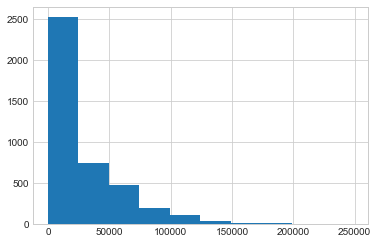

In [57]:
data['pop_density16'].hist()

---
## 1.2 Creating conditional (binary) variables prior classification:

### VLI - Very Low Income tract at 2016 -- _for additional layer on top of typologies_
- vhi2016

In [73]:
# Calculating median for vli and vli % of all hh in tract

print(data.shape)
median_vli = data['vli_16'].median()
print("the median of very low income households at the year 2016 from total households, "  
      "of all census tracts is: {:.2f}".format(median_vli))

# VLI tract (2016)
data['vli_tract16'] = np.where(data['vli_16'] > 0.5, 1, 0)
print("\nNumber of VLI tracts at 2016: {}".format(data['vli_tract16'].value_counts()[1]))

(5944, 146)
the median of very low income households at the year 2016 from total households, of all census tracts is: 0.24

Number of VLI tracts at 2016: 472


### Low Income tract
- calculate the median % of all tracts
- Binary output (0 == low income tract; 1 = not a low income tract)

In [74]:
# Calculating median for li and vli % of all hh in tract

print(data.shape)
medianli = data['vli_16'].median() + data['li_16'].median()
print("the median of low income and very low income households at the year 2016 from total households, "  
      "of all census tracts is: {:.2f}".format(medianli))

# LI 2016
data['li_tract16'] = np.where(data['vli_16']+data['li_16'] > medianli, 1, 0)
print("\nNumber of LI tracts at 2016: {}".format(data['li_tract16'].value_counts()[1]))

# LI 2000
data['li_tract00'] = np.where(data['vli_00']+data['li_00'] > (data['vli_00'].median() + data['li_00'].median()), 1, 0)
print("Number of LI tracts at 2000: {}".format(data['li_tract00'].value_counts()[1]))

# LI 1990
data['li_tract90'] = np.where(data['vli_90']+data['li_90'] > (data['vli_90'].median() + data['li_90'].median()), 1, 0)
print("Number of LI tracts at 1990: {}".format(data['li_tract90'].value_counts()[1]))

(5944, 147)
the median of low income and very low income households at the year 2016 from total households, of all census tracts is: 0.39

Number of LI tracts at 2016: 3126
Number of LI tracts at 2000: 3096
Number of LI tracts at 1990: 3111


### Ownership / Rentals oriented
Does the tract has more than 50% renters?

In [75]:
data['rentOriented_90'] = np.where(data['per_rent_90'] >= 0.5, 1, 0)
data['rentOriented_00'] = np.where(data['per_rent_00'] >= 0.5, 1, 0)
data['rentOriented_16'] = np.where(data['per_rent_16'] >= 0.5, 1, 0)

print('In 1990, {} tracts were Renters-oriented while {} Ownerships-oriented'.format(
                                            data['rentOriented_90'].value_counts()[1],
                                            data['rentOriented_90'].value_counts()[0]))
print('In 2000, {} tracts were Renters-oriented while {} Ownerships-oriented'.format(
                                            data['rentOriented_00'].value_counts()[1],
                                            data['rentOriented_00'].value_counts()[0]))
print('In 2016, {} tracts were Renters-oriented while {} Ownerships-oriented'.format(
                                            data['rentOriented_16'].value_counts()[1],
                                            data['rentOriented_16'].value_counts()[0]))

In 1990, 2359 tracts were Renters-oriented while 3585 Ownerships-oriented
In 2000, 2415 tracts were Renters-oriented while 3529 Ownerships-oriented
In 2016, 2430 tracts were Renters-oriented while 3514 Ownerships-oriented


### Rent / Home Value < regional median

In [76]:
data['rentLow_90'] = np.where((data['rentOriented_90'] == 1) &
                               (data['mrent_90']<data['mrent_90'].median()),
                               1, 0)
data['hvalLow_90'] = np.where((data['rentOriented_90'] == 0) &
                              (data['mhval_90']<data['mhval_90'].median()),
                              1, 0)
data['rentLow_00'] = np.where((data['rentOriented_00'] == 1) &
                              (data['mrent_00']<data['mrent_00'].median()),
                              1, 0)
data['hvalLow_00'] = np.where((data['rentOriented_00'] == 0) &
                              (data['mhval_00']<data['mhval_00'].median()),
                              1, 0)

### % renters > regional median

In [77]:
data['renters%90'] = np.where(data['per_rent_90'] > data['per_rent_90'].median(), 1, 0)
data['renters%00'] = np.where(data['per_rent_00'] > data['per_rent_00'].median(), 1, 0)
data['renters%16'] = np.where(data['per_rent_16'] > data['per_rent_16'].median(), 1, 0)

### % college educated < regional median 

In [78]:
data['edulow90'] = np.where(data['per_col_90'] < data['per_col_90'].median(), 1, 0)
data['edulow00'] = np.where(data['per_col_00'] < data['per_col_00'].median(), 1, 0)

### % nonwhite > regional median

In [79]:
data['nonwhiteHigh90'] = np.where(data['per_nonwhite_90'] > data['per_nonwhite_90'].median(), 1, 0)
data['nonwhiteHigh00'] = np.where(data['per_nonwhite_00'] > data['per_nonwhite_00'].median(), 1, 0)
data['nonwhiteHigh16'] = np.where(data['per_nonwhite_16'] > data['per_nonwhite_16'].median(), 1, 0)

### % of units in pre-1950 buildings > regional median

In [80]:
data['units_pre50_High'] = np.where(data['per_units_pre50'] > data['per_units_pre50'].median(), 1, 0)

### Employment density (2015) > regional median

In [81]:
data['empdens16_High'] = np.where(data['empd15'] > data['empd15'].median(), 1, 0)

### Population stable / growing 1990-2000; 2000-2016
first step: recalculating **population growth in 90-00; 00-16**

In [82]:
# recalculating popgrowth 90-00; 00-16
data['popgrowth90-00'] = data['pop_00'] - data['pop_90']
data['popgrowth00-16'] = data['pop_16'] - data['pop_00']

# Stable / Growing
data['pgrowth90-00_High'] = np.where(data['popgrowth90-00'] >= 0, 1, 0)
data['pgrowth00-16_High'] = np.where(data['popgrowth00-16'] >= 0, 1, 0)

### Population Density < regional median

In [83]:
data['popDensLow16'] = np.where(data['pop_density16'] < data['pop_density16'].median(), 1, 0)

KeyError: 'pop_density16'

### Loss of LI households 1990-2000; 2000-2016 (_absolute loss_)
- ch_all_li_count90_00 < 0
- ch_all_li_count00_16 < 0

In [ ]:
# calculate absolute loss of LI hh (vli + li)
data['ch_all_li_count90_00'] = data['vli_00'] + data['li_00'] - data['vli_90'] - data['li_90']
data['ch_all_li_count00_16'] = data['vli_16'] + data['li_16'] - data['vli_00'] - data['li_00']

data['lossLI90-00'] = np.where(data['ch_all_li_count90_00'] < 0, 1, 0)
data['lossLI00-16'] = np.where(data['ch_all_li_count00_16'] < 0, 1, 0)

### LI migration rate in 2015 < in 2009

per_all_li_mig_10 > per_all_li_mig_16

In [84]:
data['moveinLI_decrease00'] = np.where(data['per_all_li_mig_16'] < data['per_all_li_mig_10'], 1, 0)
data['moveinLI_decrease00'].value_counts()

1    3098
0    2846
Name: moveinLI_decrease00, dtype: int64

### Define Educated growth > region median
1. Calculate change in college educators % 90-00, 00-16

In [85]:
data['edu_change90-00'] = data['per_col_00'] - data['per_col_90']
data['edu_change00-16'] = data['per_col_16'] - data['per_col_00']

data['edugrowth_High90'] = np.where(data['edu_change90-00'] > data['edu_change90-00'].median(), 1, 0)
data['edugrowth_High00'] = np.where(data['edu_change00-16'] > data['edu_change00-16'].median(), 1, 0)

### % of households w children for 90,00,16 < regional median

In [86]:
data['lessChildren90'] = np.where(data['per_hhwchild_90'] < data['per_hhwchild_90'].median(), 1, 0)
data['lessChildren00'] = np.where(data['per_hhwchild_00'] < data['per_hhwchild_00'].median(), 1, 0)
data['lessChildren16'] = np.where(data['per_hhwchild_16'] < data['per_hhwchild_16'].median(), 1, 0)

### Growth in real median household income (% change) > regional median (90 and 00)

In [87]:
data['pct_ch_hinc90_00'] = data['hinc_00'] - data['hinc_90']
data['pct_ch_hinc00_16'] = data['hinc_16'] - data['hinc_00']
                                                  
data['hhIncomeGrowthHigh90'] = np.where(data['pct_ch_hinc90_00'] > data['pct_ch_hinc90_00'].median(), 1, 0)
data['hhIncomeGrowthHigh00'] = np.where(data['pct_ch_hinc00_16'] > data['pct_ch_hinc00_16'].median(), 1, 0)

### Rent change 90-00; 00-16 and home value change 90-00; 00-16 > regional median

In [88]:
# calculate rent change and hv change for 90-00 and 00-16
data['mrent90_00'] = data['mrent_00'] - data['mrent_90']
data['mhval90_00'] = data['mhval_00'] - data['mhval_90']
data['mrent00_16'] = data['mrent_16'] - data['mrent_00']
data['mhval00_16'] = data['mhval_16'] - data['mhval_00']

# 1990 base
data['rentchange_High90'] = np.where(data['mrent90_00'] > data['mrent90_00'].median(), 1, 0)
data['rhomeValchange_High90'] = np.where(data['mhval90_00'] > data['mhval90_00'].median(), 1, 0)

# 2000 base
data['rentchange_High00'] = np.where(data['mrent00_16'] > data['mrent00_16'].median(), 1, 0)
data['rhomeValchange_High00'] = np.where(data['mhval00_16'] > data['mhval00_16'].median(), 1, 0)

### Rail station (TOD)

In [89]:
print(data.shape)
data['TOD'].value_counts()

(5944, 191)


False    4304
True     1640
Name: TOD, dtype: int64

### New built housing > regional median

In [90]:
data['newBuilt_90'] = np.where(data['per_built_80_90'] > data['per_built_80_90'].median(), 1, 0)
data['newBuilt_00'] = np.where(data['per_built_90_00'] > data['per_built_90_00'].median(), 1, 0)
data['newBuilt_16'] = np.where(data['per_built_00_16'] > data['per_built_00_16'].median(), 1, 0)

### % of car-commuters > regional median

In [91]:
data['carcommuters_90'] = np.where(data['per_car_commute_90'] > data['per_car_commute_90'].median(), 1, 0)
data['carcommuters_00'] = np.where(data['per_car_commute_00'] > data['per_car_commute_00'].median(), 1, 0)

### Demographic change 90-00, 00-16 (2 out of 3 factors)

In [92]:
# Demographic change 90-00
def Dchange90(df):
    if df['edugrowth_High90'] == 1 and df['hhIncomeGrowthHigh90'] == 1:
        val = 1
    else:
        val = 0
    return val

# Demographic change 00-16
def Dchange00(df):
    if df['edugrowth_High00'] == 1 and df['hhIncomeGrowthHigh00'] == 1:
        val = 1
    else:
        val = 0
    return val


data['Dchange90'] = data.apply(Dchange90, axis=1)
data['Dchange00'] = data.apply(Dchange00, axis=1)

print(data.shape)
print("In 1990, {} tracts in the data showed demographic change".format(
                                data['Dchange90'].value_counts()[1]))
print("In 2000, {} tracts in the data showed demographic change".format(
                                data['Dchange00'].value_counts()[1]))

(5944, 198)
In 1990, 1233 tracts in the data showed demographic change
In 2000, 2173 tracts in the data showed demographic change


### 1.2 Define "Hot Market"
- Change in median real rent &gt; regional median<br>
**or**<br>
- Change in median value for owner-occupied homes &gt; regional median

In [93]:
def hotmarket90(df):
    if df['rentOriented_90'] == 1 and df['rentchange_High90'] == 1:
        val = 1
    elif df['rentOriented_90'] == 0 and df['rhomeValchange_High90'] == 1:
        val = 1
    else:
        val = 0
    return val

def hotmarket00(df):
    if df['rentOriented_00'] == 1 and df['rentchange_High00'] == 1:
        val = 1
    elif df['rentOriented_00'] == 0 and df['rhomeValchange_High00'] == 1:
        val = 1
    else:
        val = 0
    return val

data['hotmarket90'] = data.apply(hotmarket90, axis=1)
data['hotmarket00'] = data.apply(hotmarket00, axis=1)

print(data.shape)
print("In 1990, {:.2f} of the tracts in the data were defined as having a 'Hot Market'".format(
                                                     data['hotmarket90'].value_counts([1])[1]))
print("In 2000, {:.2f} of the tracts in the data were defined as having a 'Hot Market'".format(
                                                     data['hotmarket00'].value_counts([1])[1]))

(5944, 200)
In 1990, 0.51 of the tracts in the data were defined as having a 'Hot Market'
In 2000, 0.50 of the tracts in the data were defined as having a 'Hot Market'


--- 

### 1.3 Define _Vulnerable to gentrification_ in 1990 or 2000

- Housing affordable in base year (_Tract not a “Hot market”_) and (**any 2 of 4**):
    - % low income households &gt; regional median
    - % college educated &lt; regional median
    - % renters &gt; regional median
    - % nonwhite &gt; regional median

In [94]:
def vulnerable90(df):
    if df['hvalLow_90']==1 and df['li_tract90']==1 and df['edulow90']==1:
        val = 1
    elif df['hvalLow_90']==1 and df['li_tract90']==1 and df['renters%90']==1:
        val = 1
    elif df['hvalLow_90']==1 and df['li_tract90']==1 and df['nonwhiteHigh90']==1:
        val = 1
    elif df['hvalLow_90']==1 and df['edulow90']==1 and df['renters%90']==1:
        val = 1
    elif df['hvalLow_90']==1 and df['edulow90']==1 and df['nonwhiteHigh90']==1:
        val = 1
    elif df['hvalLow_90']==1 and df['renters%90']==1 and df['nonwhiteHigh90']==1:
        val = 1
    elif df['rentLow_90']==1 and df['li_tract90']==1 and df['edulow90']==1:
        val = 1
    elif df['rentLow_90']==1 and df['li_tract90']==1 and df['renters%90']==1:
        val = 1
    elif df['rentLow_90']==1 and df['li_tract90']==1 and df['nonwhiteHigh90']==1:
        val = 1
    elif df['rentLow_90']==1 and df['edulow90']==1 and df['renters%90']==1:
        val = 1
    elif df['rentLow_90']==1 and df['edulow90']==1 and df['nonwhiteHigh90']==1:
        val = 1
    elif df['rentLow_90']==1 and df['renters%90']==1 and df['nonwhiteHigh90']==1:
        val = 1
    else:
        val = 0
    return val

def vulnerable00(df):
    if df['hvalLow_00']==1 and df['li_tract00']==1 and df['edulow00']==1:
        val = 1
    elif df['hvalLow_00']==1 and df['li_tract00']==1 and df['renters%00']==1:
        val = 1
    elif df['hvalLow_00']==1 and df['li_tract00']==1 and df['nonwhiteHigh00']==1:
        val = 1
    elif df['hvalLow_00']==1 and df['edulow00']==1 and df['renters%00']==1:
        val = 1
    elif df['hvalLow_00']==1 and df['edulow00']==1 and df['nonwhiteHigh00']==1:
        val = 1
    elif df['hvalLow_00']==1 and df['renters%00']==1 and df['nonwhiteHigh00']==1:
        val = 1
    elif df['rentLow_00']==1 and df['li_tract00']==1 and df['edulow00']==1:
        val = 1
    elif df['rentLow_00']==1 and df['li_tract00']==1 and df['renters%00']==1:
        val = 1
    elif df['rentLow_00']==1 and df['li_tract00']==1 and df['nonwhiteHigh00']==1:
        val = 1
    elif df['rentLow_00']==1 and df['edulow00']==1 and df['renters%00']==1:
        val = 1
    elif df['rentLow_00']==1 and df['edulow00']==1 and df['nonwhiteHigh00']==1:
        val = 1
    elif df['rentLow_00']==1 and df['renters%00']==1 and df['nonwhiteHigh00']==1:
        val = 1
    else:
        val = 0
    return val

data['vulnerable90'] = data.apply(vulnerable90, axis=1)
data['vulnerable00'] = data.apply(vulnerable00, axis=1)

print(data.shape)
print("In 1990, {} ({:.2f} of the) tracts were defined as 'Vulnerable'".format(
                                        data['vulnerable90'].value_counts()[1],                            
                                    data['vulnerable90'].value_counts([1])[1]))
print("In 2000, {} ({:.2f} of the) tracts were defined as 'Vulnerable'".format(
                                        data['vulnerable00'].value_counts()[1],                           
                                    data['vulnerable00'].value_counts([1])[1]))

(5944, 202)
In 1990, 2456 (0.41 of the) tracts were defined as 'Vulnerable'
In 2000, 2363 (0.40 of the) tracts were defined as 'Vulnerable'


---
### 1.4 Define risk of gentrification
4 out of the 8 of the following is true in 2016:
- Located downtown
- % of units in pre-1950 buildings > regional median
- Share of renter households > regional median
- Share of households with children < regional median
- Share of recent new-build housing > regional median
- Employment density < regional median
- Population density < regional median
- “Hot market”

In [95]:
def risk16(df):
    if df['downtown'] == 1 and df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['lessChildren16'] == 1:
        val = 1
    elif df['downtown'] == 1 and df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['newBuilt_16'] == 1:
        val = 1
    elif df['downtown'] == 1 and df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['empdens16_High'] == 1:
        val = 1   
    elif df['downtown'] == 1 and df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['popDensLow16'] == 1:
        val = 1     
    elif df['downtown'] == 1 and df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['hotmarket00'] == 1:
        val = 1
    elif df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['newBuilt_16'] == 1:
        val = 1
    elif df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['empdens16_High'] == 1:
        val = 1
    elif df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['popDensLow16'] == 1:
        val = 1
    elif df['units_pre50_High'] == 1 and df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['hotmarket00'] == 1:
        val = 1    
    elif df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['newBuilt_16'] == 1 and df['empdens16_High'] == 1:
        val = 1
    elif df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['newBuilt_16'] == 1 and df['popDensLow16'] == 1:
        val = 1
    elif df['renters%16'] == 1 and df['lessChildren16'] == 1 and df['newBuilt_16'] == 1 and df['hotmarket00'] == 1:
        val = 1
    elif df['lessChildren16'] == 1 and df['newBuilt_16'] == 1 and df['empdens16_High'] == 1 and df['popDensLow16'] == 1:
        val=1
    elif df['lessChildren16'] == 1 and df['newBuilt_16'] == 1 and df['empdens16_High'] == 1 and df['hotmarket00'] == 1:
        val=1
    elif df['newBuilt_16'] == 1 and df['empdens16_High'] == 1 and df['popDensLow16'] == 1 and df['hotmarket00'] == 1:
        val=1
    else:
        val = 0
    return val

data['risk16'] = data.apply(risk16, axis=1)

print(data.shape)
print("In 2016, {} ({:.2f} of the) tracts were defined as 'at risk'".format(
                                           data['risk16'].value_counts()[1],                              
                                       data['risk16'].value_counts([1])[1]))

KeyError: ('popDensLow16', 'occurred at index 4')

### 1.5 Define risk of exclusion
3 out of the 5 of the following is true in 2016:

- % of units in prewar buildings (1950) > regional median
- Share of non-white < regional median
- Share of college-education population > regional median
- Share of car commuters > regional median
- “Hot market”

In [ ]:
def risk_Exclusion(df):
    if df['units_pre50_High'] == 1 and df['edulow00'] == 0 and df['nonwhiteHigh16'] == 0:
        val = 1
    elif df['units_pre50_High'] == 1 and df['edulow00'] == 0 and df['carcommuters_00'] == 1:
        val = 1
    elif df['units_pre50_High'] == 1 and df['edulow00'] == 0 and df['hotmarket00'] == 1:
        val = 1
    elif df['units_pre50_High'] == 1 and df['nonwhiteHigh16'] == 0 and df['carcommuters_00'] == 1:
        val = 1    
    elif df['units_pre50_High'] == 1 and df['nonwhiteHigh16'] == 0 and df['hotmarket00'] == 1:
        val = 1
    elif df['units_pre50_High'] == 1 and df['carcommuters_00'] == 1 and df['hotmarket00'] == 1:
        val = 1
    elif df['nonwhiteHigh16'] == 0 and df['carcommuters_00'] == 1 and df['hotmarket00'] == 1:
        val = 1
    elif df['nonwhiteHigh16'] == 0 and df['carcommuters_00'] == 1 and df['edulow00'] == 0:
        val=1
    elif df['hotmarket00'] == 1 and df['carcommuters_00'] == 1 and df['edulow00'] == 0:
        val=1
    else:
        val = 0
    return val

data['risk_Exclusion'] = data.apply(risk_Exclusion, axis=1)

print(data.shape)
print("In 2016, {} ({:.2f} of the) tracts were defined as 'at risk of exclusion'".format(
                                                data['risk_Exclusion'].value_counts()[1],                              
                                            data['risk_Exclusion'].value_counts([1])[1]))

### 1.6 Gentrified 90 + Gentrified 00

In [96]:
data['Gentrified90'] = np.where((data['vulnerable90'] == 1) &
                                (data['Dchange90'] == 1) &
                                (data['hotmarket90'] == 1), 1, 0)
data['Gentrified00'] = np.where((data['vulnerable00'] == 1) & 
                                (data['Dchange00'] == 1) &
                                (data['hotmarket00'] == 1), 1, 0)


print(data.shape)
print("From 1990 to 2000, {} tracts were Gentrified".format(
                     data['Gentrified90'].value_counts()[1]))
print("From 2000 to 2016, {} tracts were Gentrified".format(
                     data['Gentrified00'].value_counts()[1]))

(5944, 204)
From 1990 to 2000, 247 tracts were Gentrified
From 2000 to 2016, 225 tracts were Gentrified


---

# 2. Classify census tracts by typologies
•	If any individual variable is missing, then the whole typology is missing.

| Typology                                   | Typology Criteria  | 
| ------------------------------------------:|-------------------------------------------:|
| LI - Not Losing Low-Income Households      | - Not classified as At Risk of,            |
|                                            | Ongoing, or Advanced Gentrification        |
| ------------------------------------------ |------------------------------------------- |
| LI - At Risk of Gentrification             | - Vulnerable in 2000                       |
|                                            | - Hot Market                               |
|                                            | - At risk of Gentrification                |
| ------------------------------------------ |------------------------------------------- |


In [97]:
def Typology(df):
    '''
    classify tracts to a typology, on the range 
    between LI-not losing LI HH through displacement
    and gentrification, to exclusion of LI HH.
    Divided to four LI and four MHI typologies
    '''
    
    ## LI typologies
    # Ongoing Gentrification 
    # gentrified in 90, LI tract in 2015
    if df['li_tract16'] == 1 and df['Gentrified90'] == 1:
        val = 'LI - Ongoing Gentrification'
    # gentrified in 00, LI tract in 2015
    elif df['li_tract16'] == 1 and df['Gentrified00'] == 1:
        val = 'LI - Ongoing Gentrification'
        
    # Ongoing Displacement of Low- Income Households
    elif df['li_tract16'] == 1 and df['lossLI00-16'] == 1 and df['moveinLI_decrease00'] == 1:
        val = 'LI - Ongoing Displacement of Low- Income Households'
        
    # At Risk of Gentrification
    elif df['li_tract16'] == 1 and df['risk16'] == 1 and df['vulnerable00'] == 1 and df['hotmarket90'] == 1:
        val = 'LI - At Risk of Gentrification'
    
    # Not Losing Low-Income Households
    elif df['li_tract16'] == 1:
        val = 'LI - Not Losing Low-Income Households'
    
    ## MHI typologies
    # Advanced Gentrification 
    elif df['li_tract16'] == 0 and df['Gentrified90'] == 1:
        val = 'MHI - Advanced Gentrification' 
    elif df['li_tract16'] == 0 and df['Gentrified00'] == 1:
        val = 'MHI - Advanced Gentrification' 
        
    # Displacement of LI hh - Ongoing Exclusion 
    elif df['li_tract16'] == 0 and df['pgrowth00-16_High'] == 1 and df['lossLI00-16'] == 1 and df['moveinLI_decrease00'] == 1:
        val = 'MHI - Displacement of LI hh - Ongoing Exclusion' 
    
    # At Risk of Exclusion
    elif df['li_tract16'] == 0 and df['risk_Exclusion'] == 1:
        val = 'MHI - At Risk of Exclusion' 
    
    # Not Losing Low-Income Households
    elif df['li_tract16'] == 0:
        val = 'MHI - Not Losing Low-Income Households'

    else:
        val = "TBD"
    return val

print(data.shape)
data['Typology'] = data.apply(Typology, axis=1)
data['Typology'].value_counts()

(5944, 204)


KeyError: ('lossLI00-16', 'occurred at index 0')

In [98]:
len(pd.DataFrame(data['Typology']))#.value_counts()))

KeyError: 'Typology'

In [99]:
resultsTyp = pd.DataFrame(data['Typology'].value_counts())
resultsTyp.columns = ['tractCounts']
resultsTyp['Typology%'] = resultsTyp['tractCounts'] / resultsTyp['tractCounts'].sum() *100

resultsTyp

KeyError: 'Typology'

In [42]:
data.iloc[:3,:4]

,geometry,NAME,county,hh_00
GEOID,,,,
34003023401,"POLYGON ((-74.06457 40.887063, -74.062236 40.8...","Census Tract 234.01, Bergen County, New Jersey",3,1785.0
34003030100,"POLYGON ((-74.08288399999999 40.879418, -74.08...","Census Tract 301, Bergen County, New Jersey",3,2053.0
34003033300,"POLYGON ((-74.068018 40.889893, -74.0670339999...","Census Tract 333, Bergen County, New Jersey",3,1366.0


In [43]:
data[['Typology']]

,Typology
GEOID,
34003023401,LI - Not Losing Low-Income Households
34003030100,LI - Not Losing Low-Income Households
34003033300,LI - Not Losing Low-Income Households
34003041200,LI - Not Losing Low-Income Households
34003046300,LI - Not Losing Low-Income Households
34013000500,LI - Not Losing Low-Income Households
34013004300,LI - Not Losing Low-Income Households
34013005200,LI - Ongoing Displacement of Low- Income House...
34013007600,LI - Not Losing Low-Income Households


In [44]:
data[['Typology']].to_csv('UDPNY_results_NOV18_noMOE.csv')

([<matplotlib.patches.Wedge at 0x1a21857dd8>,
 [Text(0.424044,1.01498,''),
  Text(-1.09649,0.0878071,''),
  Text(-0.638,-0.896078,''),
  Text(-0.00502267,-1.09999,''),
  Text(0.508171,-0.975583,''),
  Text(0.818691,-0.734674,''),
  Text(1.00367,-0.450162,''),
  Text(1.08923,-0.153532,'')])

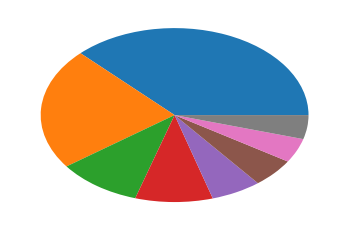

In [45]:
pl.pie(resultsTyp.iloc[:,1])